# Solve the chemical potential

## Prepare

In [2]:
import numpy as np
from numpy import linalg as la
from scipy import integrate
from scipy import optimize
from scipy import interpolate
import scipy as sp
from matplotlib import pyplot as plt

Abs = np.abs
Log = np.log
Log10 = np.log10
Pi = np.pi
Sqrt = np.sqrt
Exp = np.exp
Cos = np.cos
Sin = np.sin
Tanh = np.tanh
Sech = lambda x: 1/np.cosh(x)
ArcSin = np.arcsin
ArcTanh = np.arctanh
Arg = np.angle
BesselK = sp.special.kv
Zeta = sp.special.zeta
HeavisideTheta = lambda x: np.heaviside(x, 0)


from matplotlib import rc, rcParams
%matplotlib inline
rcParams['figure.facecolor'] = 'w'
rc('text', usetex = True)
rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amssymb}\usepackage[version=4]{mhchem}')
rc('font', size='20')
def Plot(fun, xminmax, n=100,xfun=np.linspace):
    xlist = xfun(xminmax[0], xminmax[1], n)
    ylist = [fun(x) for x in xlist]
    plt.plot(xlist, ylist)

In [3]:
A = np.array([[0.011201,1],[-0.0167777,-0.1]])

In [47]:
def B(z):
    b1 = Sech(23.44*z)**2 * (0.00660827 - 0.00311443 * Tanh(23.44*z)) - 3.3375*Tanh(23.44*z)**2 + 14.1632*Tanh(23.44*z) - 1023.05
    b2 = 0
    b3 = 0.3375*Tanh(23.44*z)**2 - 1.41632*Tanh(23.44*z) + (0.000250642*Tanh(23.44*z) - 0.000531818) * Sech(23.44*z)**2 + 102.305
    b4 = 0.125778 * Tanh(23.44*z)**2 - 0.533758 * Tanh(23.44*z) + 38.5551
    return np.array([[b1,b2],[b3,b4]])

In [231]:
B(0.1)

array([[-1.01236188,  0.        ],
       [ 0.10123981,  0.03815231]])

In [232]:
S(0.1)

array([ 0.00143615, -0.00234688])

In [5]:
def S(z):
    S1 =  (Sech(23.439999999999998*z)**2*Tanh(23.439999999999998*z)*(12.400292592738396 - 0.17167001660240072*Tanh(23.439999999999998*z) + 0.040453366034078536*Tanh(23.439999999999998*z)**2) + 
     -    Sech(23.439999999999998*z)**4*(-0.1627943323173696 + 0.07897742123550883*Tanh(23.439999999999998*z) - 0.0015932475780525888*Tanh(23.439999999999998*z)**2 + 0.0002502950281533288*Tanh(23.439999999999998*z)**3 + 
     -       1.0917805642939237e-21*Tanh(23.439999999999998*z)**4))/(306.5330232913671 - 4.243652220628149*Tanh(23.439999999999998*z) + 1.*Tanh(23.439999999999998*z)**2)
    S2 =  (Sech(23.439999999999998*z)**2*Tanh(23.439999999999998*z)*(-20.26363736715143 + 0.28053039371675903*Tanh(23.439999999999998*z) - 0.06610588689457561*Tanh(23.439999999999998*z)**2) + 
     -    Sech(23.439999999999998*z)**4*(0.2766307474583367 - 0.13420358533194254*Tanh(23.439999999999998*z) + 0.002707350201502357*Tanh(23.439999999999998*z)**2 - 0.0004253176369075176*Tanh(23.439999999999998*z)**3 - 
     -       1.855224744386806e-21*Tanh(23.439999999999998*z)**4))/(306.5330232913671 - 4.243652220628149*Tanh(23.439999999999998*z) + 1.*Tanh(23.439999999999998*z)**2)
    
    return np.array([S1,S2])

## Relaxation method

This trial is based on the following theory:

$$
A.w' + B.w = S
$$

Now we fix the w on both end. Calculate $R \equiv A.w' + B.w - S$ to see whether this agrees with 0.
Starting from initial guess of a general form $w$.

Of course this will not give 0.

But then we can talk about how to adjust $w$ to make it 0.
To adjust it, we first write the equations into discrete spacial points, i.e. bins of z-direction.

$$
A \cdot \left(\frac{w_{i+1} - w_{i-1}}{2 \Delta z}\right) + B \cdot w_i = S_i
$$
Note that $i$ is the index of spacial grids.

The direction to adjust $w_i$ is to eliminate $R$. Thus we calculate the Jacobian
$$
J_{ij} \equiv \frac{\partial R_i}{\partial w_j}
$$

Then we adjust $w_i$ by $\delta w_i$.
$$
\delta w_i = \omega \times J_{ij}^{-1} . R_j
$$

For simplicity, if $B$ dominates, then in $J$ we can directly take $J = B$. This will significantly simplify the code and calculation, but only applies when $B$ is large.

For this trial benchmark, the $B$ is indeed large.

Another trick we are using: $B$ is large. So?

Set $\tilde{w}$ = $w/W$.

Then we have

$$
A.\tilde{w}' + B.\tilde{w} = \frac{S}{W}
$$

Adjust $W$ so that the numerical difference between $S$ and $B$ are not so crazy. Then rescale back.

Converged after 42 iterations.


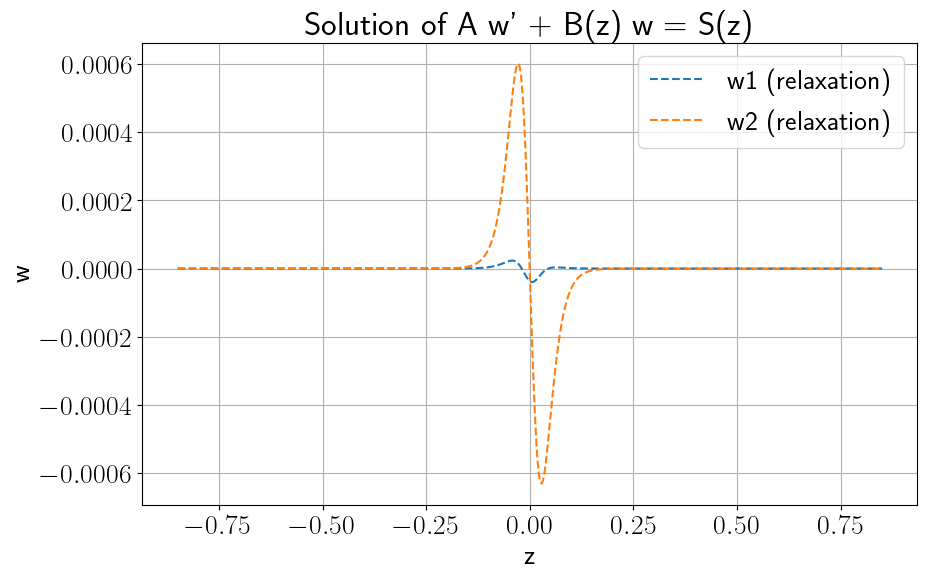

In [350]:
A_inv = np.linalg.inv(A)
W_scale = 1e-4 # Adjust based on the magnitudes of B(z) and S(z)



# Boundary conditions
w0 = np.array([0.0, 0.0]) / W_scale  # At z = 0
w1 = np.array([0.0, 0.0]) / W_scale  # At z = 1

zmin = -0.85
zmax = 0.85
# Initial mesh and initial guess
z = np.linspace(zmin, zmax, 1000)
w_init = np.zeros((2, z.size))
amplitude = 1e-10
w_init[0, :] = (amplitude / W_scale) * np.sin(np.pi * z)
w_init[1, :] = (amplitude / W_scale) * np.sin(np.pi * z)



# Relaxation method
w_scaled = np.zeros((len(z), 2))
w_scaled[:, 0] = (amplitude / W_scale) * np.sin(np.pi * z)
w_scaled[:, 1] = (amplitude / W_scale) * np.sin(np.pi * z)
w_scaled[0, :] = w0
w_scaled[-1, :] = w1

max_iterations = 10000
tolerance = 1e-10
omega = 0.5


ε = 1e-6
for iteration in range(max_iterations):
    max_delta = 0.0
    w_old = w_scaled.copy()
    dz = z[1] - z[0]
    for i in range(1, len(z) - 1):
        dw_dz = (w_scaled[i + 1, :] - w_scaled[i - 1, :]) / (2 * dz)
        Bi = B(z[i]) + ε * np.eye(2)  # Shape: (2, 2)
        Si = S(z[i]) / W_scale  # Shape: (2,)
        R = A @ dw_dz + Bi @ w_scaled[i, :] - Si
        delta_w = -np.linalg.solve(Bi, R)
        w_scaled[i, :] += omega * delta_w
        max_delta = max(max_delta, np.max(np.abs(delta_w)))
    w_scaled[0, :] = w0
    w_scaled[-1, :] = w1
    if max_delta < tolerance:
        print(f"Converged after {iteration + 1} iterations.")
        break
else:
    print("Did not converge within the maximum number of iterations.")

w_relaxation = w_scaled * W_scale  # Rescale back

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(z, w_relaxation[:, 0], '--', label='w1 (relaxation)')
plt.plot(z, w_relaxation[:, 1], '--', label='w2 (relaxation)')
plt.legend()
plt.xlabel('z')
plt.ylabel('w')
plt.title('Solution of A w\' + B(z) w = S(z)')
plt.grid(True)
plt.show()


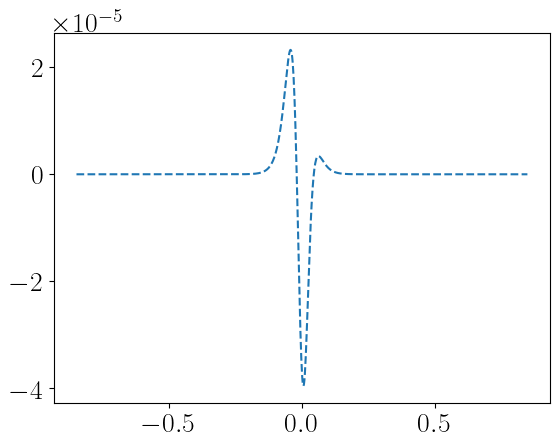

In [345]:
plt.plot(z, w_relaxation[:, 0], '--', label='w1 (relaxation)')

Plot the relative difference. If we have $R \to 0$, we finally get a small $R$.

But 'small' should be defined as 'smaller by orders of magnitude than all the terms in R'. This is the means of 'sum of several terms gives 0'.

So we compare it here.

In [142]:

rlist = np.zeros((z.size))
rlist1 = np.zeros((z.size))
for i in range(z.size-1):
    dz = z[1] - z[0]
    dw_dz = (w_relaxation[i+1]-w_relaxation[i-1])/(2*dz)
    R = (A@dw_dz + B(z[i])@w_relaxation[i] - S(z[i]))
    r = R[0]/((A@dw_dz)[0])
    r1 = R[1]/((A@dw_dz)[1])

    rlist[i] = r
    rlist1[i] = r1

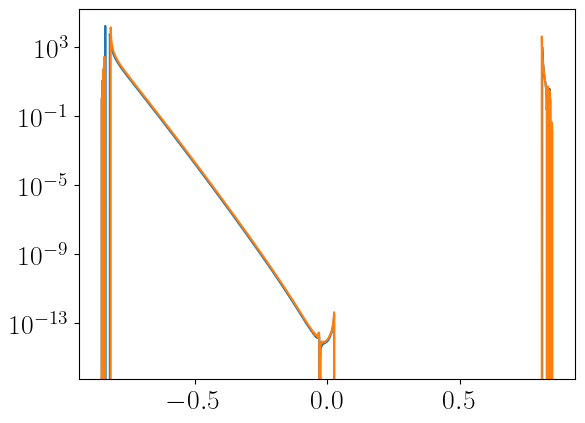

In [144]:
plt.plot(z,rlist)
plt.plot(z,rlist1)
plt.yscale('log')

## Full Jacobian

Once $B$ is not that large, we should take the full Jacobian into account.

In [20]:
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.ndimage import uniform_filter1d

The Jacobian $J$ is a 2*n matrix, where n is the number of spacial grids. We use interleaved space, i.e. the index from 1 to 2n corresponds to w1(z1), w2(z1), w1(z2), w2(z2).... instead of w1(z1) w1(z2) w1(z3) ... w2(z1) w2(z2) w3(z3)....

Converged after 2 iterations.


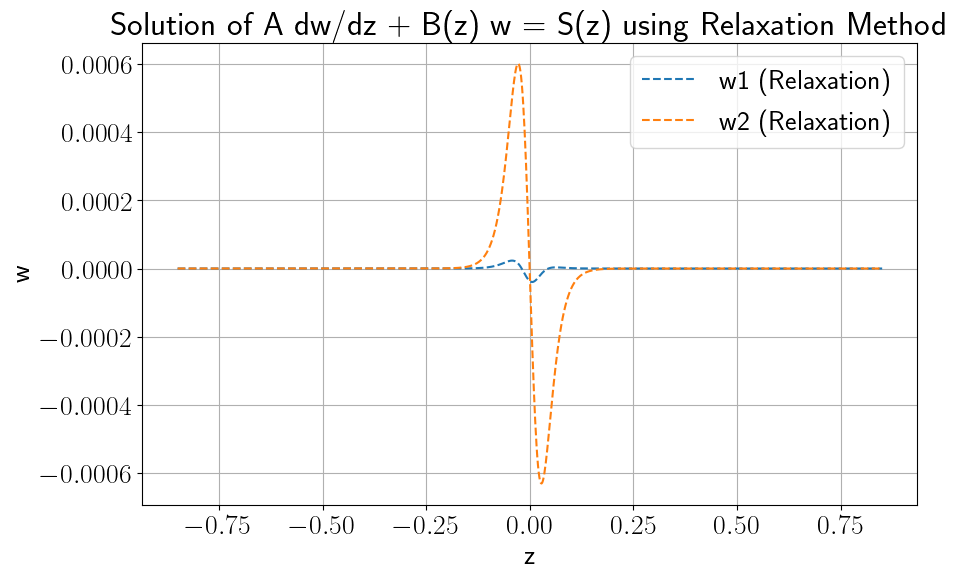

In [49]:
# Manually set Scaling Factor
W_scale = 1e-4  # Set your desired scaling factor here

# Define boundary conditions
w0 = np.array([0.0, 0.0]) / W_scale  # At z = zmin
w1 = np.array([0.0, 0.0]) / W_scale  # At z = zmax

# Initial guess for w(z)
w = np.zeros((z.size, 2))
w[0, :] = w0
w[-1, :] = w1
# Initial guess for interior points (linear interpolation)
w[1:-1, :] = (w0 + w1) / 2

# Parameters for relaxation
max_iterations = 20000
tolerance = 1e-10
omega = 1.0  # Relaxation factor

# Number of interior points
n = z.size - 2  # Exclude boundary points

# Assemble the Jacobian matrix
J = lil_matrix((2*n, 2*n))
dz = z[1] - z[0]

for i in range(n):
    row = 2*i
    z_i = z[i+1]
    
    # Partial derivatives wrt w[i-1]
    if i > 0:
        J[row, 2*(i-1)] += -A[0,0] / (2*dz)
        J[row, 2*(i-1)+1] += -A[0,1] / (2*dz)
        J[row+1, 2*(i-1)] += -A[1,0] / (2*dz)
        J[row+1, 2*(i-1)+1] += -A[1,1] / (2*dz)
    
    # Partial derivatives wrt w[i]
    Bz = B(z_i)
    J[row, 2*i] += Bz[0,0]
    J[row, 2*i+1] += Bz[0,1]
    J[row+1, 2*i] += Bz[1,0]
    J[row+1, 2*i+1] += Bz[1,1]
    
    # Partial derivatives wrt w[i+1]
    if i < n -1:
        J[row, 2*(i+1)] += A[0,0] / (2*dz)
        J[row, 2*(i+1)+1] += A[0,1] / (2*dz)
        J[row+1, 2*(i+1)] += A[1,0] / (2*dz)
        J[row+1, 2*(i+1)+1] += A[1,1] / (2*dz)

# Convert to CSR format for efficient solving
J = J.tocsr()

# Iterative Relaxation Loop
for iteration in range(max_iterations):
    # Compute residuals
    r = np.zeros(2*n)
    for i in range(n):
        row = 2*i
        z_i = z[i+1]
        
        # Compute dw/dz
        dw_dz = (w[i+2, :] - w[i, :]) / (2 * dz)
        
        # Compute residual
        residual = A @ dw_dz + B(z_i) @ w[i+1, :] - S(z_i) / W_scale
        r[row:row+2] = residual
    
    # Solve J * delta_w = -r
    delta_w = spsolve(J, -r)
    
    # Update w for interior points
    w_inner = w[1:-1, :].reshape(2*n)
    w_inner += omega * delta_w
    w[1:-1, :] = w_inner.reshape(n, 2)
    
    # Compute maximum change for convergence check
    max_delta = np.max(np.abs(delta_w))
    
    # Check for convergence
    if max_delta < tolerance:
        print(f"Converged after {iteration + 1} iterations.")
        break
    
    # Optionally adjust omega to improve convergence
    if (iteration +1 ) % 1000 == 0:
        omega *= 0.9  # Reduce omega to stabilize
        print(f"Iteration {iteration + 1}: max_delta = {max_delta:.2e}, omega adjusted to {omega:.5f}")
else:
    print("Did not converge within the maximum number of iterations.")

# Rescale the solution
w_rescaled = w * W_scale

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(z, w_rescaled[:, 0], '--', label='w1 (Relaxation)')
plt.plot(z, w_rescaled[:, 1], '--', label='w2 (Relaxation)')
plt.legend()
plt.xlabel('z')
plt.ylabel('w')
plt.title('Solution of A dw/dz + B(z) w = S(z) using Relaxation Method')
plt.grid(True)
plt.show()
